<a href="https://colab.research.google.com/github/rayxuan2000/UCSD_ECE143_project/blob/main/ECE143_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 0: Initializations and packages import**

##Initializations

In [ ]:
# install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

##Package import

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import calendar
import seaborn as sns
import folium
from IPython.display import display
from geopy.geocoders import Nominatim
import time
from collections import Counter

# Part 1: Data collection and cleaning

## Prepossessing

In [ ]:
DATASET_ID_DICTIONARY = {
  'pd_beat_codes_list_datasd.csv':
    '1Pz9ujjrsyQ3tVMJd5oe319J_SN3BcJYR',
  'pd_beats_datasd.csv':
    '1lGsC8hVlG43GWi3kjt0PN7CDwyC7JGjA',
  'pd_beats_dictionary_datasd.csv':
    '1aS6GbC5Yof4IBa2lbqPtAcWPs74rA5nQ',
  'pd_calls_for_service_2019_datasd.csv':
    '1rZX2Khi3gVw4eyJaLtvvkwLTSKow5uEE',
  'pd_calls_for_service_2020_datasd.csv':
    '1pTNygwVUobY-eX0g7idpytV0I8efjR7m',
  'pd_calls_for_service_2021_datasd.csv':
   '10jnF_wQJb1jH9H5ageuWnhNtQBWrKTuL',
  'pd_calls_for_service_2022_datasd.csv':
    '1u1q9Fh4TPSXQu3zgZrcDBgxCSOxra-KU',
  'pd_calls_for_service_2023_datasd.csv':
    '1GcFxbARDgv4HdDTQQqs6G5m3IkhZPC8H',
  'pd_calls_for_service_dictionary_datasd.csv':
   '16wGpO1cDSrDmi5FEVr6kyD_pu2c6aApL',
  'pd_cfs_calltypes_datasd.csv':
    '1ypfp_r75Bn6qYuwVdEOKwX_q9yHf8pJ3',
  'pd_dispo_codes_datasd.csv':
   '1ey_KwUEMky6SsmymzPkqQLVXwuH2FPdZ'}

In [ ]:
DATAFRAMES = {}
for files in DATASET_ID_DICTIONARY.keys():
    id = DATASET_ID_DICTIONARY[files]
    file = drive.CreateFile({'id':id})
    file.GetContentFile(files)
    df = pd.read_csv(files)
    DATAFRAMES[files] = df

## File extraction

In [ ]:
df_2019 = DATAFRAMES['pd_calls_for_service_2019_datasd.csv']
df_2020 = DATAFRAMES['pd_calls_for_service_2020_datasd.csv']
df_2021 = DATAFRAMES['pd_calls_for_service_2021_datasd.csv']
df_2022 = DATAFRAMES['pd_calls_for_service_2022_datasd.csv']
df_2023 = DATAFRAMES['pd_calls_for_service_2023_datasd.csv']

call_types_explain_df = DATAFRAMES['pd_cfs_calltypes_datasd.csv']
dispo_explain_df = DATAFRAMES['pd_dispo_codes_datasd.csv']
beat_codes_explain_df = DATAFRAMES['pd_beat_codes_list_datasd.csv']

df = pd.concat([df_2019, df_2020, df_2021, df_2022, df_2023])

## Cleaning functions

In [ ]:
def rm_empty_col(df):
    '''
    Remove empty columns
    :param df:
    :type df: df

    :returns: pandas df
    '''
    assert isinstance(df, pd.DataFrame)
    # Check which columns have all NaN values
    columns_to_drop = df.columns[df.isnull().all()]

    # Drop the columns with all NaN values
    df = df.drop(columns=columns_to_drop)

    return df

def sep_date_time(df):
    '''
    Separate date_time into date and time
    :param df: the columns we want
    :type df: df

    :returns: pandas df
    '''
    assert isinstance(df, pd.DataFrame)

    # Find the position of the "date_time" column
    date_time_column_position = df.columns.get_loc('date_time')

    # Split the "date_time" column into "date" and "time"
    df[['date', 'time']] = df['date_time'].str.split(' ', n=1, expand=True)

    # Drop the original "date_time" column
    df.drop('date_time', axis=1, inplace=True)

    # Insert the "date" and "time" columns at the original "date_time" position
    df.insert(date_time_column_position, 'date', df.pop('date'))
    df.insert(date_time_column_position + 1, 'time', df.pop('time'))

    return df

def weekdays(df):
    '''
    1 to Monday, 2 to Tuesday...0 to Sunday
    :param df:
    :type df: df

    :returns: pandas df
    '''
    assert isinstance(df, pd.DataFrame)
    day_mapping = {
        0: 'Sunday',
        1: 'Monday',
        2: 'Tuesday',
        3: 'Wednesday',
        4: 'Thursday',
        5: 'Friday',
        6: 'Saturday'
    }
    df['day_of_week'] = df['day_of_week'].map(day_mapping)
    return df

def call_types_explain(df, call_types_explain_df):
    '''
    Convert encrypted call types into readable contents
    :param df:
    :type df: df

    :returns: pandas df
    '''
    assert isinstance(df, pd.DataFrame)
    assert isinstance(call_types_explain_df, pd.DataFrame)
    code_to_explanation_mapping = dict(zip(call_types_explain_df['call_type'], call_types_explain_df['description']))
    df['call_type'] = df['call_type'].map(code_to_explanation_mapping)
    return df

def dispo_explain(df, dispo_explain_df):
    '''
    Convert encrypted disposition codes into readable contents
    :param df:
    :type df: df

    :returns: pandas df
    '''
    assert isinstance(df, pd.DataFrame)
    assert isinstance(dispo_explain_df, pd.DataFrame)
    dispo_mapping = dict(zip(dispo_explain_df['dispo_code'], dispo_explain_df['description']))
    df['disposition'] = df['disposition'].map(dispo_mapping)
    return df

def beat_codes_explain(df, beat_codes_explain_df):
    '''
    Convert beat codes into readable contents
    :param df:
    :type df: df

    :returns: pandas df
    '''
    assert isinstance(df, pd.DataFrame)
    assert isinstance(beat_codes_explain_df, pd.DataFrame)
    beat_mapping = dict(zip(beat_codes_explain_df['beat'], beat_codes_explain_df['neighborhood']))
    df['beat'] = df['beat'].map(beat_mapping)
    return df

## Data cleaning

In [ ]:
df_temp = rm_empty_col(df)
df_temp = sep_date_time(df_temp)
df_temp = weekdays(df_temp)
df_temp = call_types_explain(df_temp, call_types_explain_df)
df_temp = dispo_explain(df_temp, dispo_explain_df)
df_cleaned_saved = beat_codes_explain(df_temp, beat_codes_explain_df).\
      sort_values(by='incident_num',axis=0, ignore_index=True)

In [ ]:
df_cleaned = df_cleaned_saved

df_cleaned.rename(columns={'address_road_primary': 'Name of Street'}, inplace=True)
df_cleaned.rename(columns={'address_sfx_primary': 'Street Type'}, inplace=True)
df_cleaned.rename(columns={'disposition': 'classification'}, inplace=True)
df_cleaned.rename(columns={'beat': 'neighborhood'}, inplace=True)

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2690013 entries, 0 to 2690012
Data columns (total 13 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   incident_num               object
 1   date                       object
 2   time                       object
 3   day_of_week                object
 4   address_number_primary     int64 
 5   address_dir_primary        object
 6   Name of Street             object
 7   Street Type                object
 8   address_road_intersecting  object
 9   call_type                  object
 10  classification             object
 11  neighborhood               object
 12  priority                   int64 
dtypes: int64(2), object(11)
memory usage: 266.8+ MB


In [ ]:
df_cleaned.head()

,incident_num,date,time,day_of_week,address_number_primary,address_dir_primary,Name of Street,Street Type,address_road_intersecting,call_type,classification,neighborhood,priority
0,E19010000001,2019-01-01,00:00:01,Monday,3800,NaN,NATIONAL,AVE,NaN,ALL UNITS INFORMATION-PRI 1,"DUPLICATE CALL, XREF'D",Mountain View,1
1,E19010000002,2019-01-01,00:00:04,Monday,6500,NaN,REFLECTION,DR,NaN,DISTURBING PEACE,NO REPORT REQUIRED,Grantville,2
2,E19010000003,2019-01-01,00:00:09,Monday,0,NaN,06TH,AVE,ISLAND,FLAG DOWN/FIELD INITIATED,NO REPORT REQUIRED,Gaslamp,2
3,E19010000004,2019-01-01,00:00:19,Monday,0,NaN,VESTA,ST,MAIN,ALL UNITS INFORMATION-PRI 1,NO DISPATCH OR INCIDENT CANCLLED PRIOR TO DISP...,Barrio Logan,1
4,E19010000005,2019-01-01,00:00:31,Monday,0,NaN,04TH,AVE,ISLAND,ILLEGAL PARKING,CANCEL,Gaslamp,4


In [ ]:
df_cleaned.tail()

,incident_num,date,time,day_of_week,address_number_primary,address_dir_primary,Name of Street,Street Type,address_road_intersecting,call_type,classification,neighborhood,priority
2690008,E23120041563,2023-12-31,23:54:35,Monday,5000,NaN,FEDERAL,BLV,NaN,ADW,REPORT,Ridgeview/Webster,1
2690009,E23120041564,2023-12-31,23:56:09,Monday,7800,NaN,PARADISE VALLEY,RD,NaN,ALL UNITS INFORMATION-PRI 1,"DUPLICATE CALL, XREF'D",Bay Terraces,1
2690010,E23120041565,2023-12-31,23:56:43,Monday,2900,NaN,FELTON,ST,NaN,FIREWORK HAZARD,CANCEL,North Park,2
2690011,E23120041566,2023-12-31,23:57:11,Monday,3900,NaN,MARINE VIEW,AVE,NaN,TAMPERING W/VEH IN PROGRESS,NO REPORT REQUIRED,Shelltown,1
2690012,E23120041567,2023-12-31,23:58:53,Monday,5200,NaN,EL CAJON,BLV,NaN,DISTURBING PEACE,NO REPORT REQUIRED,Talmadge,2


# **Part 2: Exploratory data analysis and visualization**

In [ ]:
df_cleaned['address_dir_primary'].value_counts()

W     47537
S     40578
E     15920
NB     7791
SB     7648
EB     3381
WB     3003
N      1083
NW        2
NE        1
Name: address_dir_primary, dtype: int64

In [ ]:
df_cleaned['address_dir_primary'].isnull().sum()

2563069

## Analysis 1: Call based on year

In [ ]:
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])

df_year = df_cleaned['date'].dt.year
year_count = df_year.value_counts().sort_index()
print(year_count)

In [ ]:
df_cleaned.info()

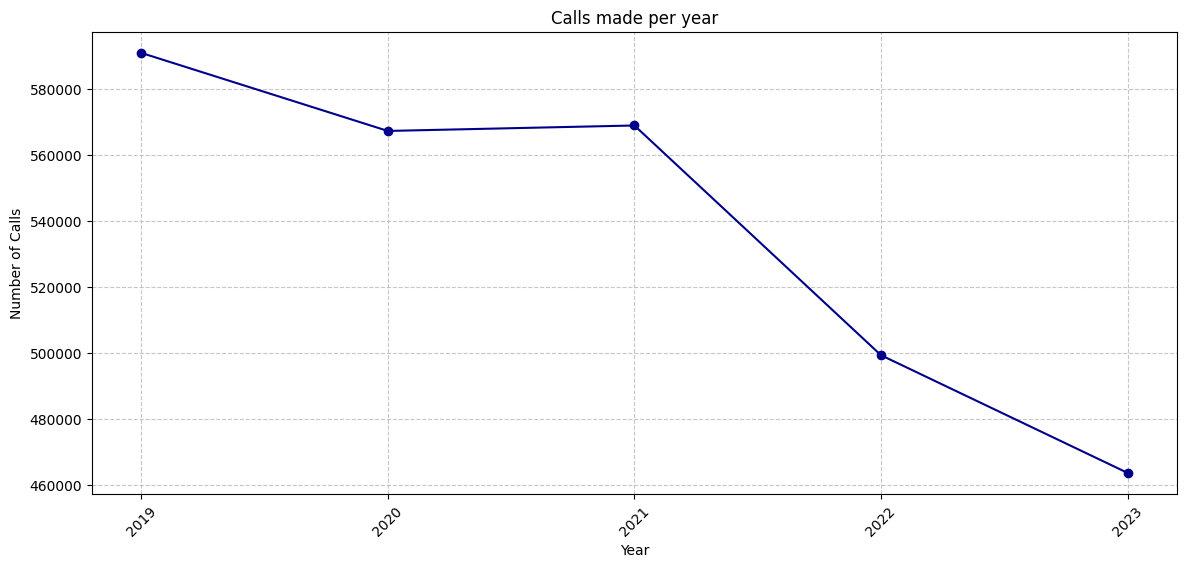

In [ ]:
plt.figure(figsize=[14,6])
year_count.plot(kind='line', marker='o', linestyle='-', color='darkblue')
plt.title('Calls made per year')
plt.xlabel('Year')
plt.ylabel('Number of Calls')
x = np.linspace(2019, 2023, num=5)
plt.xticks(x, rotation=45)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

The data shown above represents the calls separated by the year that they were made and comparing the amount of calls from year to year.

**Description:**


*   There is a general trend of descreasing police calls that are made from year to year starting from 2019 and ending in 2023
*   From 2019 to 2023, there was a 22% decrease in the amount of police calls
*   There was a very slight increase the amount of police calls from 2020 to 2021


**Conclusion:**


*   There may be many different reasons for the decrease in the amount of calls during this time period. One of the those reasons could be because of the coronavirus and less people being out of their homes which leads to less incidents that need to be reported.


## Analysis 2: Call based on month

### For all years

In [ ]:
df_cleaned['month'] = df_cleaned['date'].dt.month
df_cleaned['month'] = df_cleaned['month'].apply(lambda x: calendar.month_abbr[x])
month_count = df_cleaned['month'].value_counts().reindex(calendar.month_abbr[1:])

print(month_count)

Jan    227938
Feb    214117
Mar    235758
Apr    224509
May    229300
Jun    209725
Jul    237597
Aug    220545
Sep    226714
Oct    234465
Nov    215849
Dec    213496
Name: month, dtype: int64


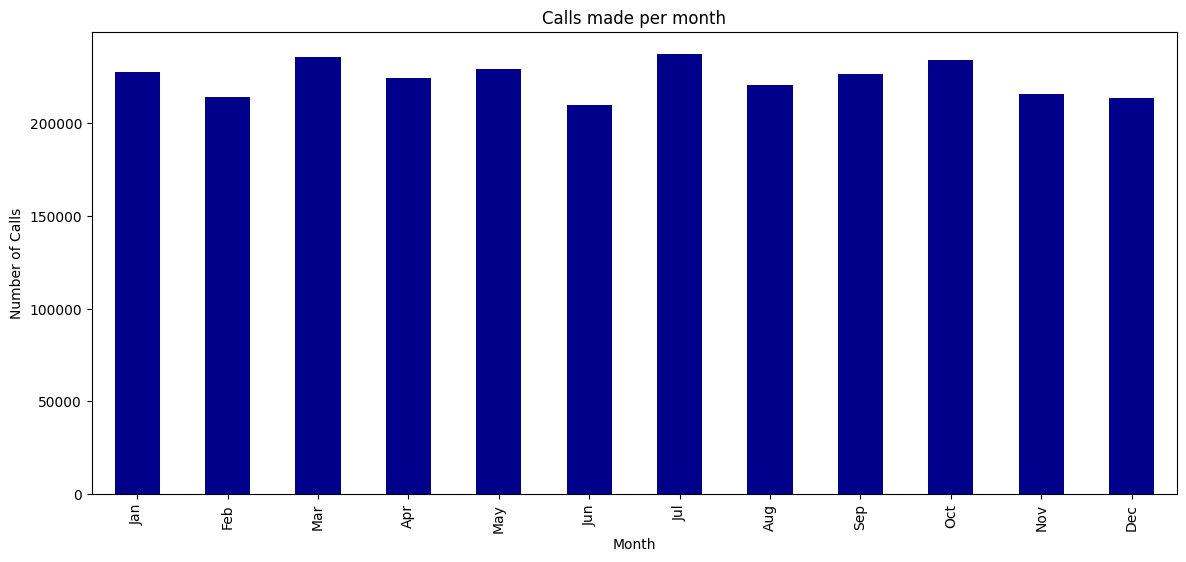

In [ ]:
plt.figure(figsize=[14,6])
month_count.plot(kind='bar',color='darkblue')
plt.title('Calls made per month')
plt.xlabel('Month')
plt.ylabel('Number of Calls')
all_months = calendar.month_abbr[1:]
plt.xticks(range(0, 12), all_months)

plt.show()

The data shown above represents the calls separated by the month that they were made and comparing the amount of calls from month to month.

**Description:**


*   The months with the most amount of police calls are July, March, and October.
*   The months with the least amount of police calles are February, June, and December
*   There is no clear trend throughout the year of a general increase of decrease in calls.



**Conclusion:**


*  July could be due to Fourth of July and the amount of firework incidents that occur during that time of year.
*  Feburary could have less amount of police calls because there are less days in the month.

### For each year

**Focus on difference between years, if there is any obvious change, think about what may cause this and search for more information such as new law, policies, and explosive news happening at that time etc. In one word, combine with practical things in life!**

In [ ]:
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])

df_cleaned['year'] = df_cleaned['date'].dt.year
df_cleaned['month'] = df_cleaned['date'].dt.month

month_year_counts = df_cleaned.groupby(['year', 'month']).size()

calls_array = np.zeros((5, 12), dtype=int)

for (year, month), count in month_year_counts.items():
    year_index = year - 2019
    month_index = month - 1
    calls_array[year_index, month_index] = count

print(calls_array)

years = range(2019, 2024)
months = pd.date_range(start='2019-01-01', periods=12, freq='M').strftime('%b')

calls_df = pd.DataFrame(calls_array, index=years, columns=months)

styled_calls_df = calls_df.style

styled_calls_df = styled_calls_df.set_properties(**{'background-color': 'lightblue',
                                                    'color': 'black',
                                                    'border-color': 'white'})
styled_calls_df



[[46402 42283 50228 48491 49923 48773 53920 53204 51370 51670 47736 46967]
 [50364 48497 48690 47985 48670 38280 48601 47860 47480 50136 44603 46124]
 [47616 45493 49276 47953 50524 48506 51598 48638 48189 45689 43416 42049]
 [41657 40793 44971 41977 42553 39627 41925 43181 40707 43123 39290 39452]
 [41899 37051 42593 38103 37630 34539 41553 27662 38968 43847 40804 38904]]


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2019,46402,42283,50228,48491,49923,48773,53920,53204,51370,51670,47736,46967
2020,50364,48497,48690,47985,48670,38280,48601,47860,47480,50136,44603,46124
2021,47616,45493,49276,47953,50524,48506,51598,48638,48189,45689,43416,42049
2022,41657,40793,44971,41977,42553,39627,41925,43181,40707,43123,39290,39452
2023,41899,37051,42593,38103,37630,34539,41553,27662,38968,43847,40804,38904


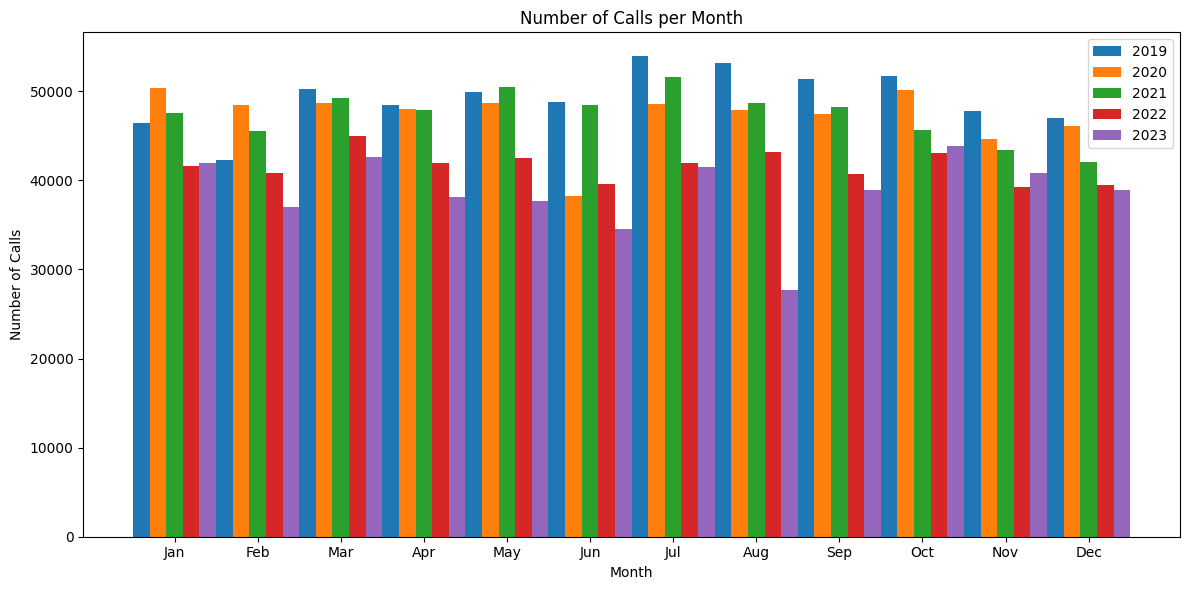

In [ ]:
plt.figure(figsize=(12, 6))

bar_width = 0.2
for i, year in enumerate(years):
    plt.bar(np.arange(len(months)) + i * bar_width, calls_df.loc[year], bar_width, label=str(year))

plt.xlabel('Month')
plt.ylabel('Number of Calls')
plt.title('Number of Calls per Month')

tick_positions = np.arange(len(months)) + (bar_width * (len(years) - 1) / 2)
plt.xticks(tick_positions, months)

plt.legend()
plt.tight_layout()
plt.show()

### Think about one more interesting topic here (to be finished)

**maybe with a fancy visualization, refering to previous presentation recordings on canvas**

## Analysis 3: Call based on days in a week (Monday, Tuesday...)

### For all years

In [ ]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

week_counts = df_cleaned['day_of_week'].value_counts(ascending = True).reindex(day_order)

print(week_counts)

Monday       348659
Tuesday      387208
Wednesday    399765
Thursday     397366
Friday       396628
Saturday     389364
Sunday        65049
Name: day_of_week, dtype: int64


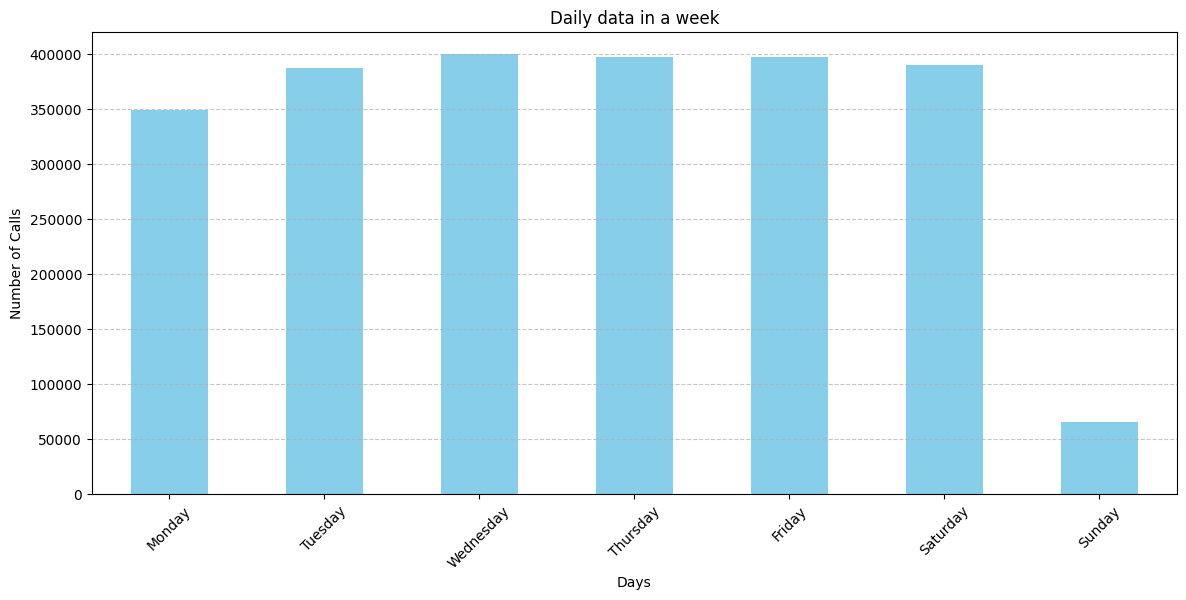

In [ ]:
# Draw a plot of week data
plt.figure(figsize=[14,6])
week_counts.plot(kind='bar', color='skyblue')
plt.title('Daily data in a week')
plt.xlabel('Days')
plt.ylabel('Number of Calls')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Based on the provided data, which represents the number of police calls received on each day of the week, we can observe the following patterns and draw some conclusions:

**Data Overview:**

Monday: 348,659 calls \\
Tuesday: 387,208 calls \\
Wednesday: 399,765 calls \\
Thursday: 397,366 calls \\
Friday: 396,628 calls \\
Saturday: 389,364 calls \\
Sunday: 65,049 calls \\

**Description:**

*   The data shows a progressive increase in the number of calls from the beginning of the workweek, starting with Monday.
*   The call volume peaks on Wednesday, which has the highest number of calls in the week.
*   After Wednesday, the call volume remains high but slightly decreases as the week progresses towards the weekend.
*   There is a noticeable drop in calls on Sunday, with the number significantly lower than any other day of the week.

**Conclusion:**


*   The weekday (Monday through Friday) consistently sees a higher volume of calls compared to the weekend (Saturday and Sunday), with a peak in the middle of the week (Wednesday).
*   The substantial decrease in call volume on Sunday could indicate that fewer incidents requiring police intervention occur on this day, or it could reflect a different pattern of public behavior and activity levels.

### For each year

**Focus on difference between years, if there is any obvious change, think about what may cause this and search for more information such as new law, policies, and explosive news happening at that time etc. In one word, combine with practical things in life!**

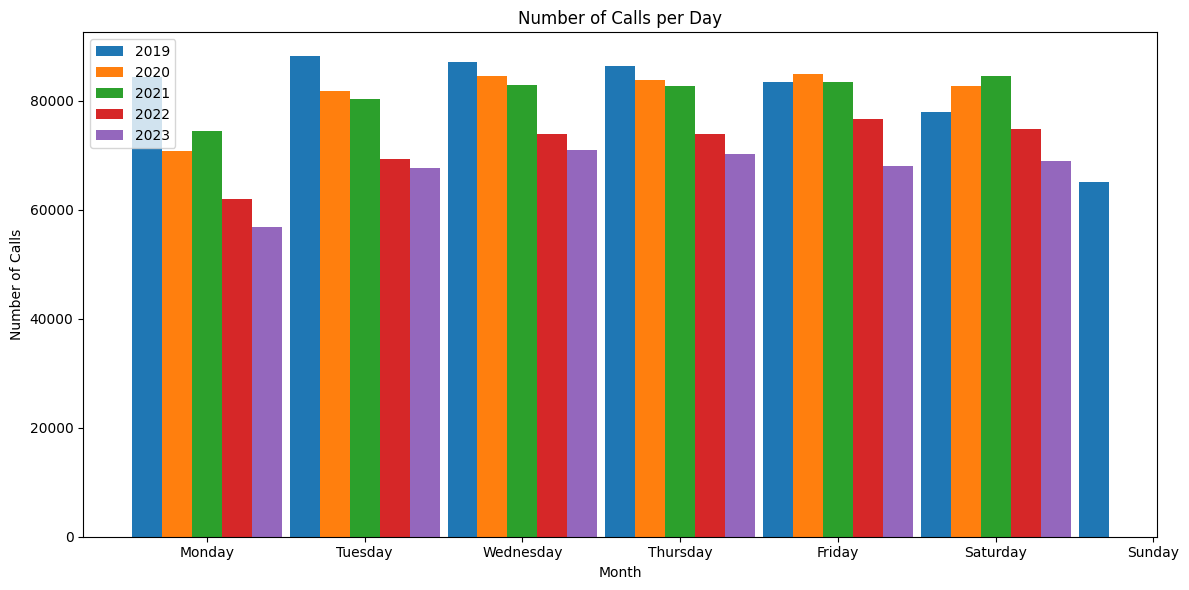

In [ ]:
day_year_counts = pd.DataFrame(df_cleaned.groupby(['year', 'day_of_week']).size())

day_yr_calls = day_year_counts.unstack(level=1)
day_yr_calls.columns = day_yr_calls.columns.droplevel(0)
day_yr_calls = day_yr_calls.reindex(columns=day_order)

plt.figure(figsize=(12, 6))

bar_width = 0.19
for i in range(len(day_yr_calls.index)):
    plt.bar(np.arange(7) + i * bar_width, day_yr_calls.values[i], bar_width)

plt.xlabel('Month')
plt.ylabel('Number of Calls')
plt.title('Number of Calls per Day')

tick_positions = np.arange(7) + (bar_width * (len(years) - 1) / 2)
plt.xticks(tick_positions, day_order)

plt.legend(range(2019,2024))
plt.tight_layout()
plt.show()


### Think about one more interesting topic here (to be finished)

**maybe with a fancy visualization, refering to previous presentation recordings on canvas**

##Analysis 4: Call based on hours (1AM-2AM, 2AM-3AM...)

In [ ]:
df_cleaned['time'] = pd.to_datetime(df_cleaned['time'], format='%H:%M:%S')
hour_counts = df_cleaned['time'].dt.hour.value_counts().sort_index()

print(hour_counts)

0      96883
1      76428
2      64183
3      49896
4      42546
5      51382
6      84953
7     128690
8     142772
9     144168
10    152643
11    144426
12    139597
13    132495
14    135647
15    138666
16    138596
17    126921
18    122321
19    116280
20    117814
21    119666
22    119987
23    103053
Name: time, dtype: int64


In [ ]:
plt.figure(figsize=[14,6])
hour_counts.plot(kind='line', marker='o', linestyle='-', color='darkblue')
plt.title('Hourly Call Counts')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Calls')
plt.xticks(range(24), rotation=45)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

The provided data represents the number of police calls received during each hour of the day. Here's a breakdown and conclusion based on the hourly call data:

**Description:**


*   The call volume starts high at midnight, decreases through the early morning hours, and reaches its lowest point around 4:00.
*   There is a sharp increase in call volume starting from 6:00, peaking at 10:00, indicating higher police call activities during the late morning hours.
*   The afternoon shows high but gradually decreasing call volumes.
*   Evening hours show an initial decrease followed by a slight increase during the 21:00 to 22:00 hours, possibly reflecting evening activities, before decreasing again towards midnight.



**Conclusion:**



*   The police department receives the highest number of calls in the late morning (10:00), which suggests that this time could be critical for staffing and resource allocation.
*   The lowest call volumes occur in the early morning (around 4:00), which might reflect the lowest activity period in the day for the general population.
*   The increase in calls late at night (21:00 to 22:00) could be associated with social activities or incidents occurring as people conclude their day.

## Analysis 5: Call type and priority

### Call Type

In [ ]:
df_cleaned['call_type'].value_counts()

DISTURBING PEACE                 240405
SELECTIVE ENFORCEMENT            144436
CHECK THE WELFARE                124531
TRAFFIC STOP WITH PLATE          123404
BURGLARY ALARM                   116880
                                  ...  
TRAFFIC CONTROL-COST RECOVERY         2
INTERAGAENCY MUTUAL AID               1
SOCIAL HOST-COST RECOVERY             1
VANDALISM,ALARM                       1
EJECTED FROM AN EVENT                 1
Name: call_type, Length: 252, dtype: int64

**Only considering top 90% categories since the remaining contains lots of categories while the total number of them is very small.**

In [ ]:
# Calculate the 90% count of each category in the column
median_count = df_cleaned['call_type'].value_counts().quantile(0.90)

# Get counts of each category in the column
category_counts = df_cleaned['call_type'].value_counts()

# Filter categories based on their count being greater than the 90%
categories_bigger_than_median = category_counts[category_counts > median_count]

# Return category names and their counts
categories_with_counts_bigger_than_median = {category: count for category,
                                             count in categories_bigger_than_median.items()}

categories_with_counts_bigger_than_median

{'DISTURBING PEACE': 240405,
 'SELECTIVE ENFORCEMENT': 144436,
 'CHECK THE WELFARE': 124531,
 'TRAFFIC STOP WITH PLATE': 123404,
 'BURGLARY ALARM': 116880,
 'ILLEGAL PARKING': 86548,
 'SPECIAL DETAIL': 78787,
 'DISTURBING PEACE W/VIOLENCE': 74182,
 'TRAFFIC STOP FROM THE MOBILE COMPUTER': 71673,
 'MENTAL CASE': 69250,
 'UNK EMERG, HANG UP/OPEN LINE': 64120,
 'PED STOP/FIELD INTERVIEW': 63406,
 'FOLLOW-UP BY FIELD UNIT': 56166,
 'DISTURBING PEACE NOISE ONLY': 46322,
 'NO DETAIL ACCIDENT': 43106,
 'IN A MEETING/OUT OF SERVICE': 41288,
 'FLAG DOWN/FIELD INITIATED': 38920,
 'ALL UNITS INFORMATION-PRI 2': 38694,
 'HAZARDOUS CONDITION': 37597,
 'REQUEST FOR TOW TRUCK': 35949,
 'INFORMATION FOR DISPATCHERS': 34955,
 'LOUD PARTY': 34754,
 'CAR THEFT REPORT': 33126,
 'TRESPASSING': 32372,
 'PRISONER IN CUSTODY': 31978,
 'BATTERY': 27353}

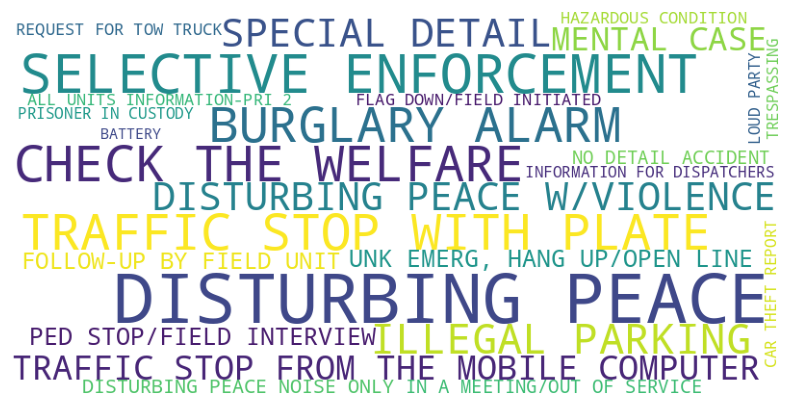

In [ ]:
from wordcloud import WordCloud

def generate_wordcloud(word_dict):
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='antialiased')
    plt.axis('off')
    plt.show()

generate_wordcloud(categories_with_counts_bigger_than_median)


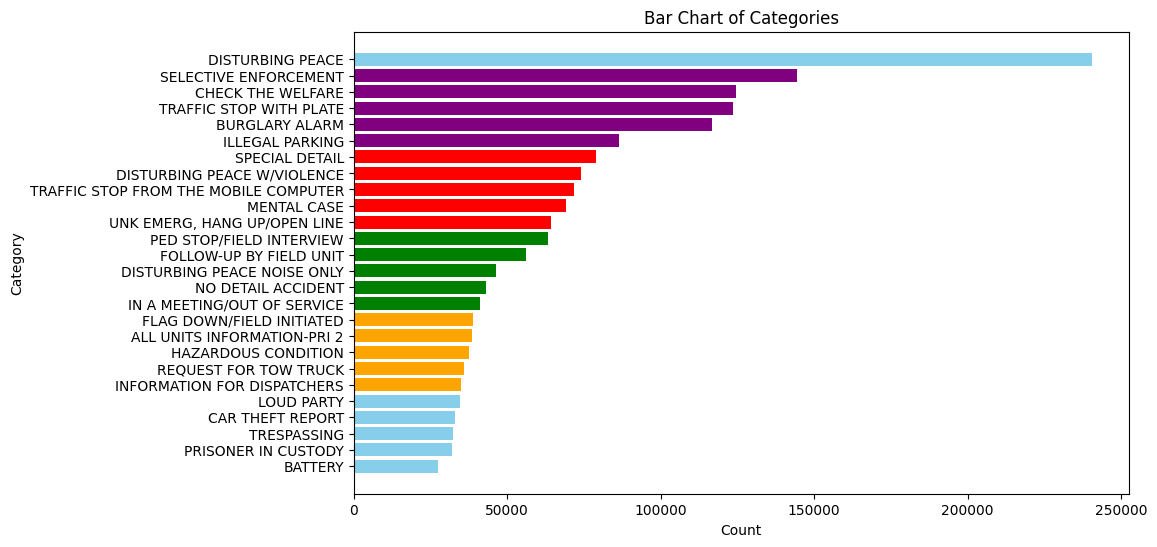

In [ ]:
# Extract keys and values from the dictionary
sorted_data = \
   sorted(categories_with_counts_bigger_than_median.items(), key=lambda x: x[1])

categories = [item[0] for item in sorted_data]
counts = [item[1] for item in sorted_data]

# Define the number of bars in each group
bars_per_group = 5

# Calculate the number of groups
num_groups = len(categories) // bars_per_group + (len(categories) % bars_per_group > 0)

# Define color scheme
colors = ['skyblue', 'orange', 'green', 'red', 'purple']

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust size if needed

for i in range(num_groups):
    start_idx = i * bars_per_group
    end_idx = min((i + 1) * bars_per_group, len(categories))
    plt.barh(categories[start_idx:end_idx], counts[start_idx:end_idx], color=colors[i % len(colors)])

plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Bar Chart of Categories')
plt.show()

In [ ]:
# data = {
#     'DISTURBING PEACE': 240405,
#     'SELECTIVE ENFORCEMENT': 144436,
#     'CHECK THE WELFARE': 124531,
#     'TRAFFIC STOP WITH PLATE': 123404,
#     'BURGLARY ALARM': 116880,
#     'ILLEGAL PARKING': 86548,
#     'SPECIAL DETAIL': 78787,
#     'DISTURBING PEACE W/VIOLENCE': 74182,
#     'TRAFFIC STOP FROM THE MOBILE COMPUTER': 71673,
#     'MENTAL CASE': 69250,
#     'UNK EMERG, HANG UP/OPEN LINE': 64120,
#     'PED STOP/FIELD INTERVIEW': 63406,
#     'FOLLOW-UP BY FIELD UNIT': 56166,
#     'DISTURBING PEACE NOISE ONLY': 46322,
#     'NO DETAIL ACCIDENT': 43106,
#     'IN A MEETING/OUT OF SERVICE': 41288,
#     'FLAG DOWN/FIELD INITIATED': 38920,
#     'ALL UNITS INFORMATION-PRI 2': 38694,
#     'HAZARDOUS CONDITION': 37597,
#     'REQUEST FOR TOW TRUCK': 35949,
#     'INFORMATION FOR DISPATCHERS': 34955,
#     'LOUD PARTY': 34754,
#     'CAR THEFT REPORT': 33126,
#     'TRESPASSING': 32372,
#     'PRISONER IN CUSTODY': 31978,
#     'BATTERY': 27353
# }

# # Classification based on the analysis
# classification = {
#     'Disturbance': ['DISTURBING PEACE', 'DISTURBING PEACE W/VIOLENCE', 'DISTURBING PEACE NOISE ONLY'],
#     'Law Enforcement': ['SELECTIVE ENFORCEMENT', 'TRAFFIC STOP WITH PLATE', 'PED STOP/FIELD INTERVIEW'],
#     'Emergency': ['UNK EMERG, HANG UP/OPEN LINE', 'ALL UNITS INFORMATION-PRI 2'],
#     'Burglary/Theft': ['BURGLARY ALARM', 'CAR THEFT REPORT', 'TRESPASSING'],
#     'Non-Emergency': ['ILLEGAL PARKING', 'LOUD PARTY', 'INFORMATION FOR DISPATCHERS'],
#     'Mental Health': ['MENTAL CASE']
# }

# # Color for each classification
# colors = {
#     'Disturbance': 'blue',
#     'Law Enforcement': 'orange',
#     'Emergency': 'green',
#     'Burglary/Theft': 'red',
#     'Non-Emergency': 'purple',
#     'Mental Health': 'brown'
# }

# # Group data by classification
# grouped_data = {key: sum(data[c] for c in value) for key, value in classification.items()}

# # Sort grouped data based on values
# sorted_grouped_data = dict(sorted(grouped_data.items(), key=lambda item: item[1], reverse=True))

# plt.figure(figsize=(5, 4))
# plt.barh(range(len(sorted_grouped_data)), list(sorted_grouped_data.values()), color=[colors[key] for key in sorted_grouped_data.keys()])
# plt.yticks(range(len(sorted_grouped_data)), list(sorted_grouped_data.keys()))
# plt.xlabel('Number of Calls')
# plt.title('Police Call Types in San Diego')
# plt.show()

### Priority

**Hint: Find top 3 call types in each priority group. Also compare it with priority file here: http://seshat.datasd.org/pd/pd_cfs_priority_defs_datasd.pdf. Illustrate your findings.**

In [ ]:
df_cleaned['priority'].value_counts()

2    1214273
3     593453
1     518906
4     166088
0     143810
9      53453
5         20
7          6
8          4
Name: priority, dtype: int64

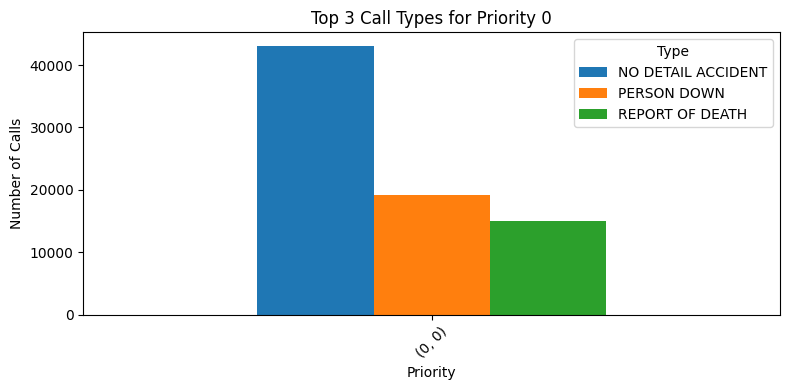

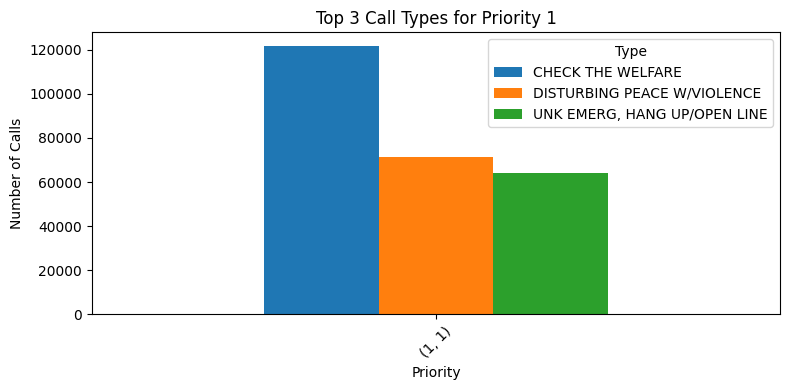

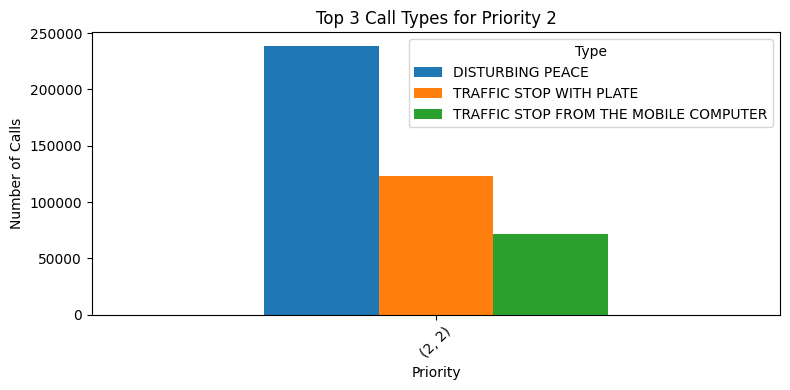

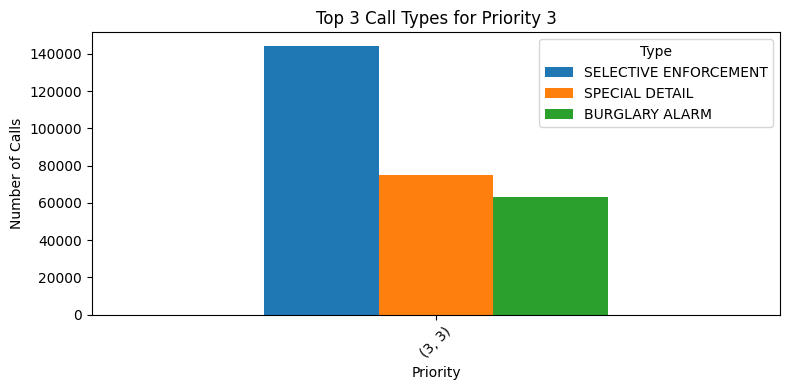

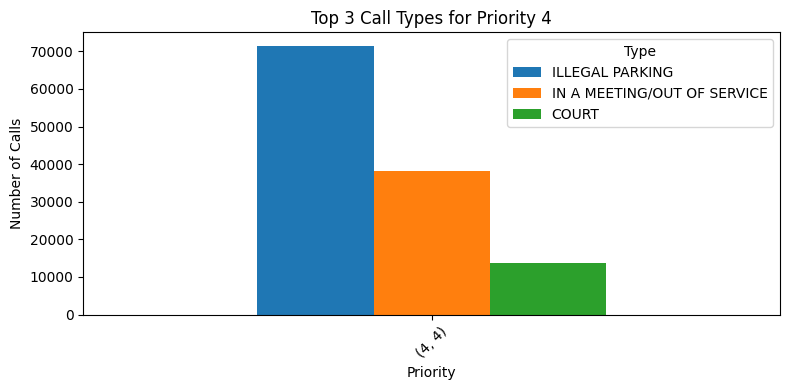

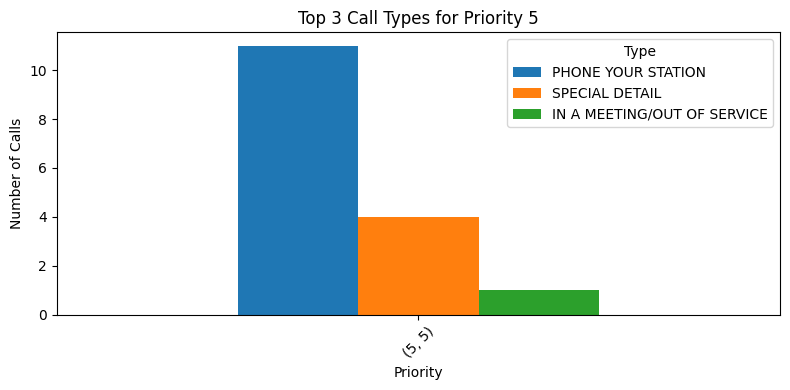

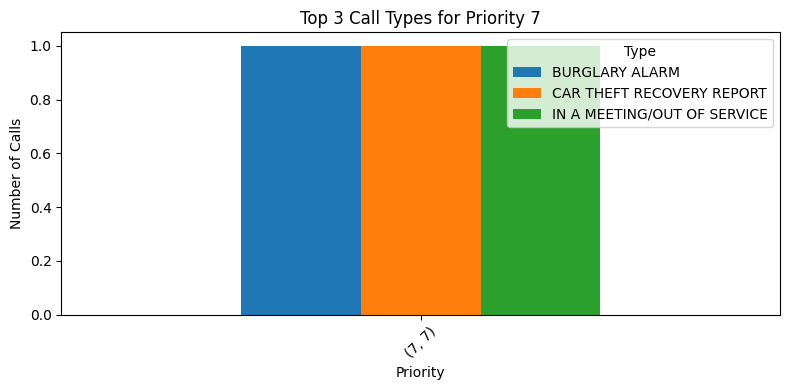

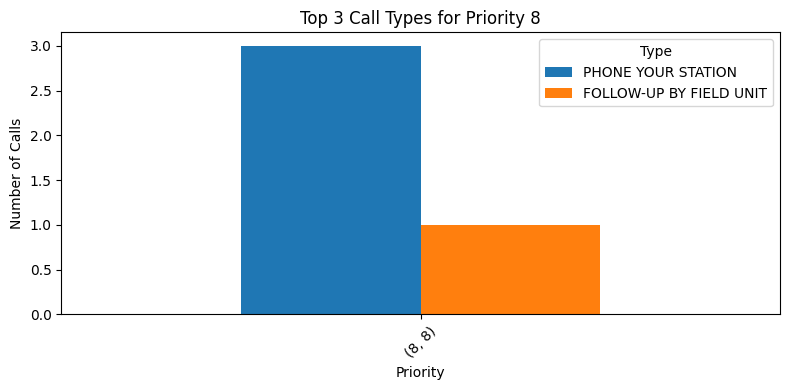

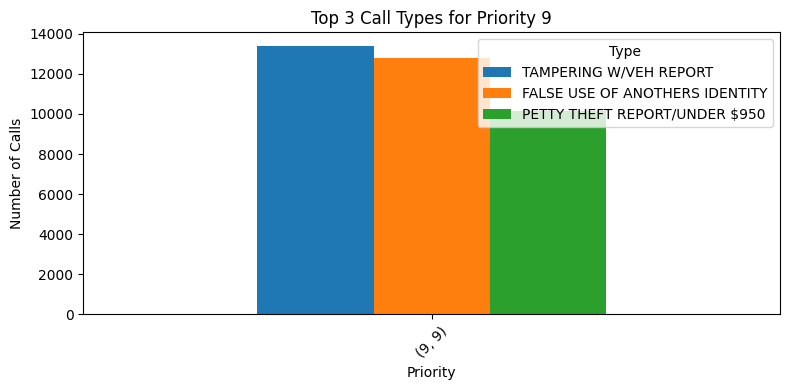

In [ ]:

# Group by priority and count the occurrences of each call type
grouped = df_cleaned.groupby('priority')['call_type'].value_counts()

# Get the top 3 call types for each priority group
top_3_call_types = grouped.groupby(level=0).nlargest(3)

# Iterate over each priority group and plot individual graphs
for priority, data in top_3_call_types.groupby(level=0):
    data.unstack().plot(kind='bar', figsize=(8, 4))
    plt.title(f'Top 3 Call Types for Priority {priority}')
    plt.xlabel('Priority')
    plt.ylabel('Number of Calls')
    plt.legend(title='Type', loc='upper right')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Analysis 6: Disposition

In [ ]:
df_cleaned['classification'].value_counts()

NO REPORT REQUIRED                                              1385288
OTHER                                                            429195
REPORT                                                           237040
CANCEL                                                           216838
NO DISPATCH OR INCIDENT CANCLLED PRIOR TO DISPATCHING A UNIT     176132
ARREST MADE                                                      105668
UNFOUNDED                                                         64290
DUPLICATE CALL, XREF'D                                            48150
STOLEN VEHICLE OR RECOVERED VEHICLE                                9295
DISPATCHED ALARM CALL CANCELLED BEFORE UNIT ONSCENE                5819
NO FURTHER ACTION, HIGH RISK (CRISIS RESPONSE TEAM)                3501
NO REPORT REQUIRED, BOARD AND SECURE                                205
OTHER, HIGH RISK (CRISIS RESPONSE TEAM)                             183
DUPLICATE CALL                                                  

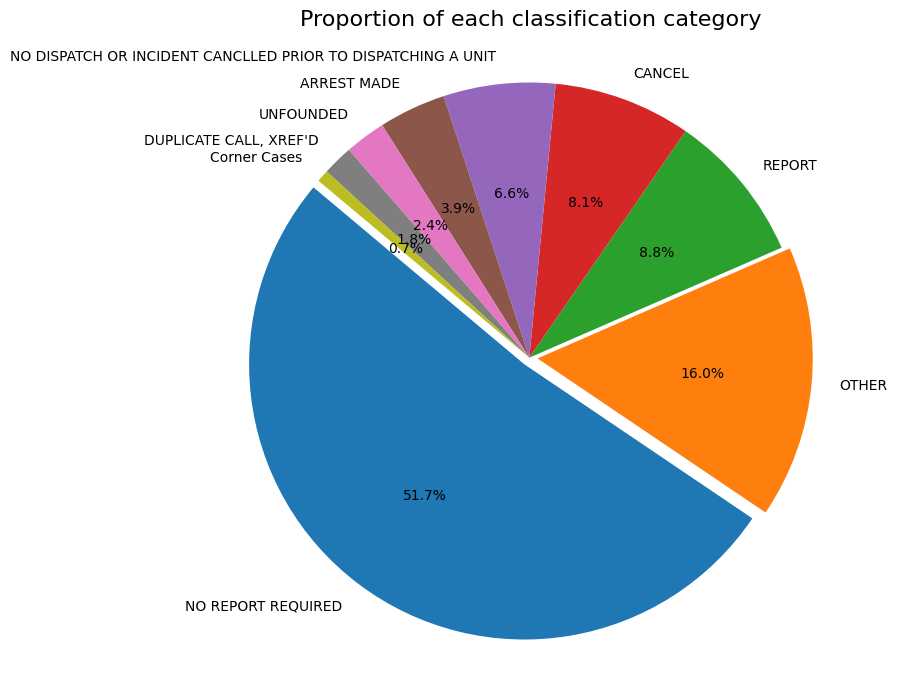

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

explode = (0.03, 0.03, 0, 0, 0, 0, 0, 0, 0)
# Calculate the proportion of each category
category_counts = df_cleaned['classification'].value_counts()
total_count = category_counts.sum()
proportions = category_counts / total_count

# Combine categories with proportions less than 1%
threshold = 0.01
proportions_to_combine = proportions[proportions < threshold]
proportions_combined = proportions.copy()
proportions_combined['Corner Cases'] = proportions_to_combine.sum()
proportions_combined.drop(proportions_to_combine.index, inplace=True)

# Plotting the pie chart
plt.figure(figsize=(8, 6))  # You can adjust the figure size as needed
plt.pie(proportions_combined, labels=proportions_combined.index, autopct='%1.1f%%',
        startangle=140, textprops={'fontsize': 10}, explode = explode)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportion of each classification category', fontsize=16)

# Adjusting the distance between title and pie chart
plt.subplots_adjust(top=1.2)  # You can adjust the top parameter to control the distance

plt.show()


## Analysis pro: Map visualization

In [ ]:
df_cleaned['neighborhood'].value_counts()

East Village            136515
Pacific Beach           108722
Core-Columbia            81027
Midway District          73688
North Park               70746
                         ...  
Qualcomm                  1397
Burlingame                 703
Broadway Heights           695
Tijuana River Valley       599
Islenair                   498
Name: neighborhood, Length: 125, dtype: int64

In [ ]:
# Convert column to a list
street_names_list = df_cleaned['neighborhood'].tolist()

# Count occurrences of each element
counts = Counter(street_names_list)

# Sort elements based on occurrence from highest to lowest
sorted_street_names = sorted(counts, key=counts.get, reverse=True)
modified_street_names = [str(name) + ', San Diego' for name in sorted_street_names]

In [ ]:
def get_coordinates_with_retry(street_names, max_retries=3):
    """
    Get the coordinates (latitude, longitude) of a list of street names using Nominatim geocoder with retry.

    Parameters:
        street_names (list): A list of street names to geocode.
        max_retries (int): Maximum number of retries in case of timeout.

    Returns:
        dict: A dictionary mapping street names to their corresponding coordinates.
    """
    # Initialize Nominatim geocoder
    geolocator = Nominatim(user_agent="my_geocoder")

    coordinates_dict = {}
    successful_street = []
    failed_street = []

    for street_name in street_names:
        retries = 0
        while retries < max_retries:
            try:
                # Geocode the street name
                location = geolocator.geocode(street_name, timeout=10)  # Increase timeout to 10 seconds
                if location:
                    coordinates_dict[street_name] = (location.latitude, location.longitude)
                    successful_street.append(street_name)
                    break  # Break out of retry loop if successful
                else:
                    # print(f"Could not find coordinates for street: {street_name}")
                    print(f"Failed to retrieve coordinates for {street_name}")
                    failed_street.append(street_name)
                    break  # Break out of retry loop if unsuccessful
            except Exception as e:
                print(f"Error: {e}")
                print(f"Retry attempt {retries + 1} for street: {street_name}...")
                retries += 1
                time.sleep(1)  # Wait for 1 second before retrying

        # if street_name not in coordinates_dict:
        #     print(f"Failed to retrieve coordinates for {street_name}")
        #     failed_street.append(street_name)

    return coordinates_dict, successful_street, failed_street

In [ ]:
# street_names = modified_street_names
# coordinates_dict,successful_street, failed_street = get_coordinates_with_retry(street_names)

In [ ]:
# Change name so that our api can retrieve the approximate location above.

# 'Clairemont Mesa East': 'Mt Abernathy Ave': (32.8216288, -117.1758409)
# 'Point Loma Heights': 'Nimitz Blvd': (32.7398929, -117.2341953)
# 'College East': 'Curry Dr' : (32.768158, -117.059387)
# 'Teralta West': '41st St' : (32.7501724, -117.1069388)
# 'College West': 'Maisel Way' : (32.766739, -117.07972)
# 'Bay Ho': 'Wayne Ln' : (32.819734, -117.216176)
# 'Ridgeview/Webster': 'Tilden St' : (32.725075, -117.092957)
# 'Roseville/Fleet Ridge': 'Emerson St' : (32.7277165, -117.2361453)
# 'Fairmount Village': '46th St' : (32.7530387, -117.0954746)
# 'Clairemont Mesa West': 'Mt Augustus Ave' : (32.80891, -117.189537)
# 'Jamacha/Lomita': 'Sabre St' : (32.712188, -117.029024)
# 'Miramar Ranch North': 'Waterton Rd' : (32.928745, -117.093857)
# 'Fox Canyon': 'Auburn Dr' : (32.741562, -117.08876)
# 'Torrey Preserve': 'N Torrey Pines Rd' : (32.8860104, -117.2439253)

In [ ]:
# Dictionary mapping old names to new names
name_map = {'Clairemont Mesa East': 'Mt Abernathy Ave',
            'Point Loma Heights': 'Nimitz Blvd',
            'College East': 'Curry Dr',
            'Teralta West': '41st St',
            'College West': 'Maisel Way',
            'Bay Ho': 'Wayne Ln',
            'Ridgeview/Webster': 'Tilden St',
            'Roseville/Fleet Ridge': 'Emerson St',
            'Fairmount Village': '46th St',
            'Clairemont Mesa West': 'Mt Augustus Ave',
            'Jamacha/Lomita': 'Sabre St',
            'Miramar Ranch North': 'Waterton Rd',
            'Fox Canyon': 'Auburn Dr',
            'Torrey Preserve': 'N Torrey Pines Rd'}

# Column and dictionary to be used for replacement
column_to_replace = 'neighborhood'

df_cleaned_updated = df_cleaned.copy()

# Replacing names in the specified column using the dictionary
df_cleaned_updated[column_to_replace] = \
   df_cleaned_updated[column_to_replace].replace(name_map)

# Convert column to a list
street_names_list_updated = df_cleaned_updated['neighborhood'].tolist()

# Count occurrences of each element
counts = Counter(street_names_list_updated)

# Sort elements based on occurrence from highest to lowest
sorted_street_names = sorted(counts, key=counts.get, reverse=True)

modified_street_names_updated = [str(name) + ', San Diego' for name in sorted_street_names]

**Below may take some time (more than one minute)**

In [ ]:
coordinates_dict, successful_street, failed_street = \
  get_coordinates_with_retry(modified_street_names_updated)

In [ ]:
# # Modify this wrong position
# coordinates_dict['North City, San Diego'] = (32.974891, -117.232049)

# # San Diego coordinates
# san_diego_coords = (32.8860104, -117.2439253)

# # Create a map centered around San Diego
# mymap = folium.Map(location=san_diego_coords, zoom_start=12)

# # Add marker for each street name and its coordinates
# for street_name, coords in coordinates_dict.items():
#     folium.Marker(location=coords, popup=street_name).add_to(mymap)

# # Display the map directly within Jupyter notebook
# display(mymap)

In [ ]:
# Accurate to six decimal places
coordinates_dict = {key: (round(value[0], 6), round(value[1], 6)) \
                    for key, value in coordinates_dict.items()}

# Create a dictionary to store the combined information
combined_dict = {}

# Iterate over the keys of the counter object
for ele in list(counts.items()):
    street_name, count = ele
    street_name = str(street_name) + ', San Diego'
    # Check if the street name exists in the street_coordinates dictionary
    if street_name in coordinates_dict:
        combined_dict[street_name] = [coordinates_dict[street_name], count]

sorted_keys = sorted(combined_dict.keys(), \
                       key=lambda x: combined_dict[x][1], reverse=True)

combined_dict['North City, San Diego'] = [(32.974891, -117.232049), 6786]
combined_dict = {key: combined_dict[key] for key in sorted_keys}

In [ ]:
combined_dict

{'East Village, San Diego': [(32.713731, -117.15364), 136515],
 'Pacific Beach, San Diego': [(32.797827, -117.240318), 108722],
 'Core-Columbia, San Diego': [(32.716964, -117.170067), 81027],
 'Midway District, San Diego': [(32.713796, -117.1752), 73688],
 'North Park, San Diego': [(32.748388, -117.130156), 70746],
 'Kearny Mesa, San Diego': [(32.828924, -117.142415), 67313],
 'Hillcrest, San Diego': [(32.74829, -117.160976), 65393],
 'La Jolla, San Diego': [(32.840162, -117.274078), 57739],
 'Mira Mesa, San Diego': [(32.915602, -117.143923), 56718],
 'Logan Heights, San Diego': [(32.699219, -117.129476), 55779],
 'Ocean Beach, San Diego': [(32.744807, -117.247607), 54125],
 'San Ysidro, San Diego': [(32.552001, -117.043081), 51061],
 'University City, San Diego': [(32.87265, -117.214022), 49748],
 'Mission Valley East, San Diego': [(33.123098, -117.08168), 48366],
 'nan, San Diego': [(-29.599282, -51.926), 44842],
 'Carmel Valley, San Diego': [(32.943434, -117.213979), 43860],
 'Gasla

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors

# # Define the number of colors in the gradient
# num_colors = 10

# # Create a colormap from blue to red
# cmap = plt.cm.get_cmap('bwr')

# # Generate a list of gradient colors
# gradient_colors = [mcolors.rgb2hex(cmap(i / num_colors)) for i in range(num_colors)]

# # Display the list of gradient colors
# print(gradient_colors)

In [ ]:
import folium
from folium.plugins import FloatImage

# Create a map centered at San Diego
m = folium.Map(location=[32.7157, -117.1611], zoom_start=13)

# Grouping numbers incrementally
groups = [(0, 15000, 'pink'), (15001, 30000, 'purple'), \
          (30001, 45000, 'blue'), (45001, 60000, 'cyan'), \
          (60001, 75000, 'green'), (75001, 90000, 'yellow'), \
          (105001, 120000, 'orange'), (135001, 150000, 'red')]

# Define legend HTML
legend_html = """
     <div style="position: fixed;
                 bottom: 50px; left: 50px; width: 180px; height: 210px;
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:white;
                 ">
        <b>Notation:</b> <br>
        <table style="width:100%">
            <tr>
                <td>0 - 15,000</td>
                <td><svg height="20" width="20">
                    <circle cx="10" cy="10" r="6" fill="pink" />
                    </svg></td>
            </tr>
            <tr>
                <td>15,001 - 30,000</td>
                <td><svg height="20" width="20">
                    <circle cx="10" cy="10" r="6" fill="purple" />
                    </svg></td>
            </tr>
            <tr>
                <td>30,001 - 45,000</td>
                <td><svg height="20" width="20">
                    <circle cx="10" cy="10" r="6" fill="blue" />
                    </svg></td>
            </tr>
            <tr>
                <td>45,001 - 60,000</td>
                <td><svg height="20" width="20">
                    <circle cx="10" cy="10" r="6" fill="cyan" />
                    </svg></td>
            </tr>
            <tr>
                <td>60,001 - 75,000</td>
                <td><svg height="20" width="20">
                    <circle cx="10" cy="10" r="6" fill="green" />
                    </svg></td>
            </tr>
            <tr>
                <td>75,001 - 90,000</td>
                <td><svg height="20" width="20">
                    <circle cx="10" cy="10" r="6" fill="yellow" />
                    </svg></td>
            </tr>
            <tr>
                <td>105,001 - 120,000</td>
                <td><svg height="20" width="20">
                    <circle cx="10" cy="10" r="6" fill="orange" />
                    </svg></td>
            </tr>
            <tr>
                <td>135,001 - 150,000</td>
                <td><svg height="20" width="20">
                    <circle cx="10" cy="10" r="6" fill="red" />
                    </svg></td>
            </tr>
        </table>
      </div>
     """

# Plot streets with different color flags based on nums
for street, (coordinates, num) in combined_dict.items():
    for start, end, color in groups:
        if start <= num <= end:
            folium.Marker(location=coordinates, \
                          icon=folium.Icon(color='white', icon_color=color), \
                          icon_size=(300, 300),\
                          popup=f'{street}, Num: {num}').add_to(m)
            break  # Exit the loop once the color is assigned

# Add legend to the map
m.get_root().html.add_child(folium.Element(legend_html))

# Save the map to an HTML file and open it in a new tab
m.save('map_with_legend.html')

m